In [1]:
!nproc & nvidia-smi -L

20
GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-125eaf29-537f-5e5a-8a00-140ef5b42572)


In [2]:
import os
import time
import json
import random
import itertools
from functools import partial
from collections import defaultdict
from pprint import pprint

import pandas as pd
import numpy as np
import networkx as nx

import timm
import torch
import textdistance

import matplotlib.pyplot as plt
import seaborn as sns
import ipyplot as iplt
from IPython.display import HTML, display
from tqdm.notebook import tqdm
tqdm.pandas()

from typing import Dict, List, Any

import faiss
faiss.omp_set_num_threads(16)

data_dir = "/data/"

In [3]:
from dotenv import load_dotenv; load_dotenv()
from s3fs import S3FileSystem
s3 = S3FileSystem()
%load_ext sql

In [4]:
df = pd.read_parquet("s3://aisle3-ml-datasets/product-matching/aisle3/main.parquet")
df

,id,variant_id,title,merchant,brand,gender,color,imid,image_url,image,pose,color_pred
0,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26789,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/allso...,side_shot,black
1,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26790,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/allso...,side_shot,black
2,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26791,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/allso...,side_shot,black
3,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26792,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/allso...,upper_shot,black
4,allsole.10491511,allsole.10491633,Vans Authentic Canvas Trainers,allsole,vans,unisex,Black,26793,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/allso...,partial_shot,black
...,...,...,...,...,...,...,...,...,...,...,...,...
215424,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95785,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/ssens...,partial_shot,maroon
215425,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95786,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/ssens...,pair_shot,white
215426,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95787,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/ssens...,side_shot,white
215427,ssense.221903M237021,ssense.221903M237021,Coach 1941 Black & Off-White Logo Slide Sandals,ssense,coach,men,Chalk black,95788,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/ssens...,pair_shot,beige


In [5]:
df.image = df.image.str.replace("s3://", "") + ".jpg"
df.image

0         aisle-3-image-final/images/original/allsole/al...
1         aisle-3-image-final/images/original/allsole/al...
2         aisle-3-image-final/images/original/allsole/al...
3         aisle-3-image-final/images/original/allsole/al...
4         aisle-3-image-final/images/original/allsole/al...
                                ...                        
215424    aisle-3-image-final/images/original/ssense/sse...
215425    aisle-3-image-final/images/original/ssense/sse...
215426    aisle-3-image-final/images/original/ssense/sse...
215427    aisle-3-image-final/images/original/ssense/sse...
215428    aisle-3-image-final/images/original/ssense/sse...
Name: image, Length: 215429, dtype: object

In [6]:
(data_dir + df.image).apply(os.path.isfile).value_counts()

True    215429
Name: image, dtype: int64

In [7]:
test_df = pd.read_parquet("product_matching_test.parquet")
test_df

,id,variant_id,title,merchant,brand,gender,color,imid,image_url,image,pose,color_pred,label
0,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87044,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,beige,2002
1,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87045,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,white,2002
2,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87046,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,beige,2002
3,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87047,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,pair_shot,white,2002
4,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87048,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,sole_shot,brown,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27280,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86991,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,black,843
27281,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86992,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,black,843
27282,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86993,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,pair_shot,navy,843
27283,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86994,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,sole_shot,black,843


In [8]:
test_df.id.nunique()

5732

In [9]:
test_df.label.nunique()

2454

In [10]:
test_df.label.max()

2453

In [11]:
test_df.groupby("label").id.unique().apply(len).value_counts()

2     1898
3      361
4      145
5       38
6        8
9        2
10       1
7        1
Name: id, dtype: int64

In [12]:
G = nx.Graph()
test_df.groupby("label").id.unique().apply(partial(itertools.combinations, r=2)).apply(
    G.add_edges_from
)
print(
    f"Number of edges : {G.number_of_edges()} | Number of nodes : {G.number_of_nodes()}"
)

clusters = sorted(nx.connected_components(G), key=len, reverse=True)
pd.Series(clusters).apply(len).value_counts().sort_index()


Number of edges : 4489 | Number of nodes : 5732


2     1898
3      361
4      145
5       38
6        8
7        1
9        2
10       1
dtype: int64

In [7]:
%%sql result << 
SELECT
    `source`,
    `target`,
    `match`
FROM gold_annotations

1190 rows affected.
Returning data to local variable result


In [8]:
annotations = result.DataFrame()

In [9]:
annotations.match.value_counts()

0    797
1    393
Name: match, dtype: int64

In [10]:
print(
    "ids in annotations not in main:",
    len(np.setdiff1d(np.union1d(annotations.source, annotations.target), df.id)),
)


ids in annotations not in main: 0


In [11]:
G = nx.Graph()
G.add_nodes_from(np.union1d(annotations.source, annotations.target))
G.add_edges_from(annotations.loc[annotations.match == 1, ["source", "target"]].values)
print(
    f"Number of nodes: {G.number_of_nodes()} | Number of edges: {G.number_of_edges()}"
)
clusters = sorted(nx.connected_components(G), key=len, reverse=True)
pd.Series(clusters).apply(len).value_counts().sort_index()


Number of nodes: 655 | Number of edges: 393


1    116
2    198
3     25
4     11
5      3
9      1
dtype: int64

In [13]:
df.set_index("id", drop=False, inplace=True)
df.imid = range(len(df))

In [14]:
# df = df.loc[set.union(*clusters), :]
# df.imid = range(len(df))
# df

In [15]:
pred_meta_subset = ["id", "imid", "gender", "merchant", "brand", "pose", "color_pred"]
pred_df = df.loc[set.union(*clusters), pred_meta_subset].copy().reset_index(drop=True)
pred_df

,id,imid,gender,merchant,brand,pose,color_pred
0,allsole.12731049,1677,women,allsole,coach,side_shot,tan
1,allsole.12731049,1678,women,allsole,coach,sole_shot,tan
2,allsole.12731049,1679,women,allsole,coach,upper_shot,tan
3,allsole.12731049,1680,women,allsole,coach,partial_shot,tan
4,asos.1917764,31774,men,asos,puma,partial_shot,white
...,...,...,...,...,...,...,...
27445,schuh.1974347270,131935,women,schuh,vans,side_shot,black
27446,schuh.1778927060,128800,women,schuh,teva,side_shot,black
27447,schuh.1778927060,128801,women,schuh,teva,non_available,black
27448,schuh.1778927060,128802,women,schuh,teva,partial_shot,black


In [16]:
def viz(
    frame: pd.DataFrame,
    image_size: int = 200,
    max_images: int = None,
    **kwargs: Dict[str, List[Any]],
) -> None:
    frame = frame.reset_index(drop=True)

    extra_df = None
    if len(kwargs):
        extra_df = pd.DataFrame(kwargs)
        assert len(extra_df) == len(frame), "kwargs must have same length as frame"
        for col in extra_df.columns:
            extra_df[col] = f"{col} : " + extra_df[col].astype(str)

    html = iplt.plot_images(
        frame.image_url,
        labels=frame.id,
        custom_texts="<HR>"
        + (
            ""
            if extra_df is None
            else ("<HR>" + extra_df.apply(" <br> ".join, axis=1) + "<HR><HR>")
        )
        + frame.title
        + "<HR>"
        + frame[["merchant", "brand", "gender", "color"]].apply(" -- ".join, axis=1),
        img_width=image_size,
        show_url=False,
        max_images=max_images if max_images else len(frame),
    )


viz(df.tail(4), dist=np.linspace(0.1, 0.9, 4))


# Build image features

Fetch image model

In [17]:
# image_model = "s3://aisle3-ml-models/product-matching/image/arcface:v1.5/model.pth"
# image_model = "s3://aisle3-ml-models/product-matching/image/arcface:v1.5/model_v1.pth"
# s3.download(image_model, "model.pth")

load model

In [18]:
# model = torch.jit.load("model.pth").cuda().eval()
# model = timm.create_model("vit_base_resnet50_384", num_classes=0, pretrained=True).cuda().eval()
# model.default_cfg

Dataset and Inference transforms

In [19]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
import torchvision
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

# transform = create_transform(**resolve_data_config({}, model=model))
# transform

def normalize(image, **kwargs):
    return np.clip(image.astype(np.float32) / 255.0, 0.0, 1.0)

transform = A.Compose(
    [
        A.Resize(
            256,
            256,
            interpolation=cv2.INTER_AREA,
        ),
        A.Lambda(image=normalize),
        ToTensorV2(),
    ]
)


In [20]:
from torch.utils.data import Dataset, DataLoader


class ImageDataset(Dataset):
    def __init__(
        self,
        df,
        transforms=None,
        backend="pil",
        image_col: str = "image",
        label_col: str = None,
        data_dir="/data/",
    ):
        super().__init__()
        self.df = df
        self.image_col = image_col
        self.label_col = label_col
        self.data_dir = data_dir
        self.backend = backend
        self.transforms = transforms

    def read_image(self, fimg):
        fimg = os.path.join(self.data_dir, fimg)
        if self.backend == "cv2":
            img = cv2.imread(fimg)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img

        elif self.backend == "pil":
            with open(fimg, "rb") as f:
                img = Image.open(f)
                img = img.convert("RGB")
                return img
        else:
            raise ValueError(
                f"Unknown backend: {self.backend}; should be either 'cv2' or 'pil'"
            )

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        fimg = self.df.at[idx, self.image_col]
        img = self.read_image(fimg)

        if self.transforms is not None:
            if self.backend == "cv2":
                img = self.transforms(image=img)["image"]
            elif self.backend == "pil":
                img = self.transforms(img)

        if self.label_col:
            label = self.df.at[idx, self.label_col]
            return img, label
        return img


dataset = ImageDataset(
    df.reset_index(drop=True).copy(),
    backend="cv2",
    transforms=transform,
    data_dir="/data/",
    image_col="image",
)
dataset[0].shape


torch.Size([3, 256, 256])

In [21]:
# dataloader = DataLoader(dataset, batch_size=96, shuffle=False, num_workers=16)

# features = list()
# with torch.no_grad():
#     for img in tqdm(dataloader):
#         feat = model(img.cuda(non_blocking=True))
#         features.append(feat.detach().cpu())

# features = torch.cat(features, dim=0)
# print(features.shape)
# features = features.cpu().numpy()
# features /= np.linalg.norm(features, axis=1, keepdims=True)

# # np.save("features.npy", features)

# del model
# torch.cuda.empty_cache()

In [22]:
features = np.load("ld_features.npy")
print(features.shape)

(215429, 512)


In [23]:
index = faiss.IndexFlatL2(features.shape[1])
index.add(features)
index.ntotal

215429

# Get Baseline

In [24]:
def loc(frame, idx, col):
    result = frame.loc[idx, col]
    if isinstance(result, pd.Series):
        result = result.iloc[0]
    return result

apply blocking for ground truth pairwise matches

In [25]:
ground_truth = dict()
for cluster in clusters:
    for anchor in cluster:
        matches = cluster.copy()
        for col in ["brand", "gender"]:
            matches = [match for match in matches if loc(df, match, col) == loc(df, anchor, col)]
        for col in ["merchant"]:
            matches = [match for match in matches if loc(df, match, col) != loc(df, anchor, col)]
        ground_truth[anchor] = [anchor] + matches
len(ground_truth)

5732

In [26]:
pred_df["ground_truth"] = pred_df.id.map(ground_truth)
pred_df

,id,imid,gender,merchant,brand,pose,color_pred,ground_truth
0,allsole.12731049,1677,women,allsole,coach,side_shot,tan,"[allsole.12731049, coggles.12731049]"
1,allsole.12731049,1678,women,allsole,coach,sole_shot,tan,"[allsole.12731049, coggles.12731049]"
2,allsole.12731049,1679,women,allsole,coach,upper_shot,tan,"[allsole.12731049, coggles.12731049]"
3,allsole.12731049,1680,women,allsole,coach,partial_shot,tan,"[allsole.12731049, coggles.12731049]"
4,asos.1917764,31774,men,asos,puma,partial_shot,white,"[asos.1917764, schuh.3444917760]"
...,...,...,...,...,...,...,...,...
27445,schuh.1974347270,131935,women,schuh,vans,side_shot,black,"[schuh.1974347270, asos.2010112, allsole.11433..."
27446,schuh.1778927060,128800,women,schuh,teva,side_shot,black,"[schuh.1778927060, asos.1400319]"
27447,schuh.1778927060,128801,women,schuh,teva,non_available,black,"[schuh.1778927060, asos.1400319]"
27448,schuh.1778927060,128802,women,schuh,teva,partial_shot,black,"[schuh.1778927060, asos.1400319]"


In [27]:
pred_df.groupby("id").ground_truth.apply(len).value_counts().sort_index()

1      182
2       77
3      160
4     2301
5     1047
6     1758
7       75
8       91
9       22
10      13
11       6
Name: ground_truth, dtype: int64

In [28]:
def compute_scores(pred, gt):
    tp = len(np.intersect1d(pred, gt))
    iou = tp / len(np.union1d(pred, gt))
    # fp = np.setdiff1d(pred, gt)
    if tp == 0:
        prec, recall, f1 = (0.0, 0.0, 0.0)
    else:
        prec = tp / len(pred)
        recall = tp / len(gt)
        f1 = (2 * prec * recall) / (prec + recall)
    return {"iou": iou, "prec": prec, "recall": recall, "f1": f1}


def get_nn_imgs(imids, k=50, threshold=None):
    if isinstance(imids, int):
        imids = [imids]
    qx = features[imids]
    D, I = index.search(qx, k=k)
    if threshold is None:
        threshold = D.max()
    mask = np.argwhere(np.logical_and(I != -1, D < threshold))
    nns = list()
    for i, nn in itertools.groupby(mask, lambda x: x[0]):
        nn = np.vstack(list(nn))
        nns.append(
            [
                (idx, dist)
                for idx, dist in zip(
                    I[nn[:, 0], nn[:, 1]].tolist(), D[nn[:, 0], nn[:, 1]].tolist()
                )
            ]
        )
    return nns


def perform_blocking(nns, block_on=["gender", "brand"], block_off=["merchant"]):
    if len(nns) > 1:
        q_imid = nns[0][0]
        query = df.iloc[q_imid]
        for col in block_on:
            nns = [nn for nn in nns if query[col] == df.iloc[nn[0]][col]]
        if len(block_off):
            for col in block_off:
                nns = [nn for nn in nns if query[col] != df.iloc[nn[0]][col]]
        nns = [(q_imid, 0.0)] + nns
    return nns


def imids_to_id(imids):
    return df.iloc[imids, 0].unique()


def id_to_imids(ids):
    imids = df.loc[ids, "imid"]
    if isinstance(imids, int):
        return [imids]
    return imids


def apply_threshold(nns, threshold=0.5, similarity=False):
    return [nn[0] for nn in nns if nn[1] < threshold]


In [29]:
# get nns with dists
print("peforming index search")
t = time.perf_counter()
nns = get_nn_imgs(pred_df.imid.values, k=100)
print("time to search:", time.perf_counter() - t)

# blocking
print("peforming blocking")
t = time.perf_counter()
nns = [perform_blocking(nn) for nn in nns]
print("time to perform blocking:", time.perf_counter() - t)

nns = dict(zip(pred_df.imid.values, nns))
len(nns)

peforming index search
time to search: 117.961456541
peforming blocking
time to perform blocking: 316.75754327


27450

In [30]:
def perform_eval(preds):
    scores = list()
    for pred, gt in zip(preds, pred_df.ground_truth):
        scores.append(compute_scores(pred, gt))
    scores = pd.DataFrame(scores)
    return scores.mean().to_dict()

threshold = 0.5
perform_eval(pred_df.imid.map(nns).apply(partial(apply_threshold, threshold=threshold)).apply(imids_to_id))

{'iou': 0.54366539872105,
 'prec': 0.9666380694587863,
 'recall': 0.5551097377627432,
 'f1': 0.6734466339825095}

  0%|          | 0/28 [00:00<?, ?it/s]

best f1:
{'f1': 0.7075419521411606,
 'iou': 0.5933891089465064,
 'prec': 0.8980505087460853,
 'recall': 0.6478889033451875,
 'threshold': 0.6500000000000001}


,iou,prec,recall,f1,threshold
0,0.442174,0.989114,0.442200,0.599248,0.10
1,0.449277,0.989089,0.449346,0.604244,0.15
2,0.456721,0.988907,0.456896,0.609590,0.20
3,0.465510,0.988349,0.465924,0.615903,0.25
4,0.476109,0.987459,0.476942,0.623586,0.30
5,0.489162,0.985863,0.490819,0.633320,0.35
6,0.505607,0.982651,0.508805,0.645557,0.40
7,0.523969,0.976238,0.530323,0.659033,0.45
8,0.543665,0.966638,0.555110,0.673447,0.50
9,0.565283,0.951892,0.585513,0.688961,0.55


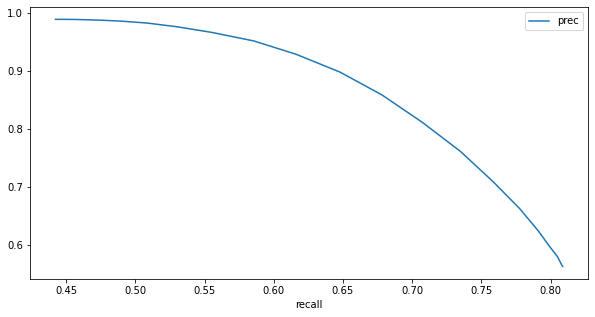

In [31]:
sweep = list()
tmp = pred_df.imid.map(nns)

for threshold in tqdm(np.arange(0.1, 1.5, 0.05)):
    scores = perform_eval(tmp.apply(partial(apply_threshold, threshold=threshold)).apply(imids_to_id))
    scores["threshold"] = threshold
    sweep.append(scores)
sweep = pd.DataFrame(sweep)
sweep.plot.line(x="recall", y="prec", figsize=(10, 5))
print("best f1:")
pprint(sweep.iloc[sweep.f1.argmax()].to_dict())
sweep

In [34]:
df.pose.value_counts()

pair_shot          59832
side_shot          54196
partial_shot       31670
human_wear_shot    23285
upper_shot         12811
3qrt_shot          12510
sole_shot          11058
heel_shot           8256
non_available       1811
Name: pose, dtype: int64

In [35]:
pred_df.set_index("imid", drop=False, inplace=True)
pred_df

,id,imid,gender,merchant,brand,pose,color_pred,ground_truth
imid,,,,,,,,
1677,allsole.12731049,1677,women,allsole,coach,side_shot,tan,"[allsole.12731049, coggles.12731049]"
1678,allsole.12731049,1678,women,allsole,coach,sole_shot,tan,"[allsole.12731049, coggles.12731049]"
1679,allsole.12731049,1679,women,allsole,coach,upper_shot,tan,"[allsole.12731049, coggles.12731049]"
1680,allsole.12731049,1680,women,allsole,coach,partial_shot,tan,"[allsole.12731049, coggles.12731049]"
31774,asos.1917764,31774,men,asos,puma,partial_shot,white,"[asos.1917764, schuh.3444917760]"
...,...,...,...,...,...,...,...,...
131935,schuh.1974347270,131935,women,schuh,vans,side_shot,black,"[schuh.1974347270, asos.2010112, allsole.11433..."
128800,schuh.1778927060,128800,women,schuh,teva,side_shot,black,"[schuh.1778927060, asos.1400319]"
128801,schuh.1778927060,128801,women,schuh,teva,non_available,black,"[schuh.1778927060, asos.1400319]"


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

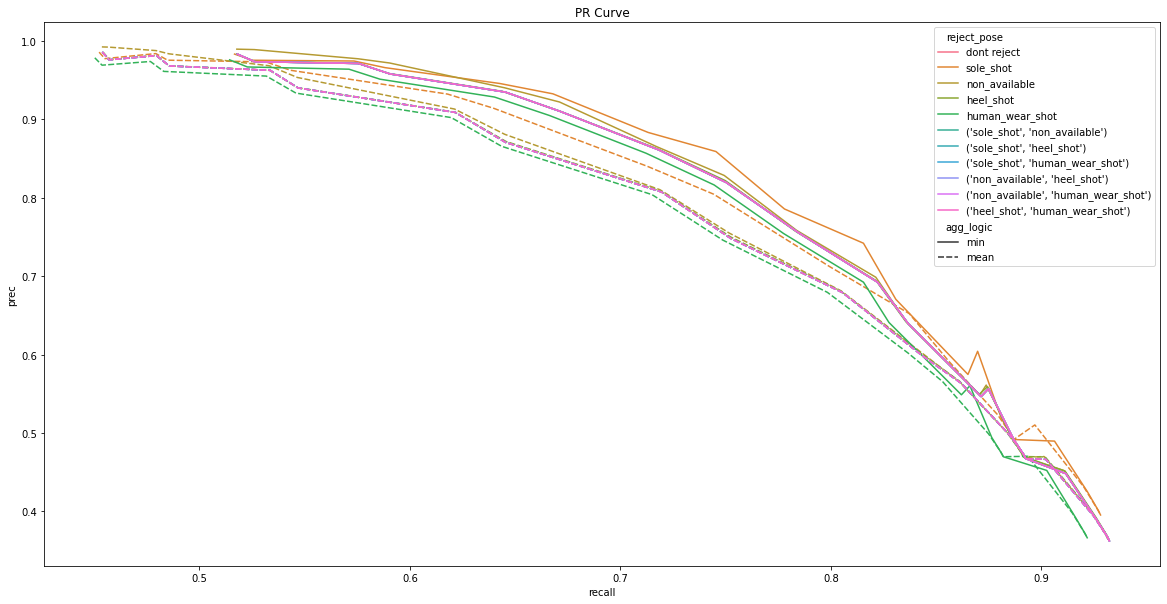

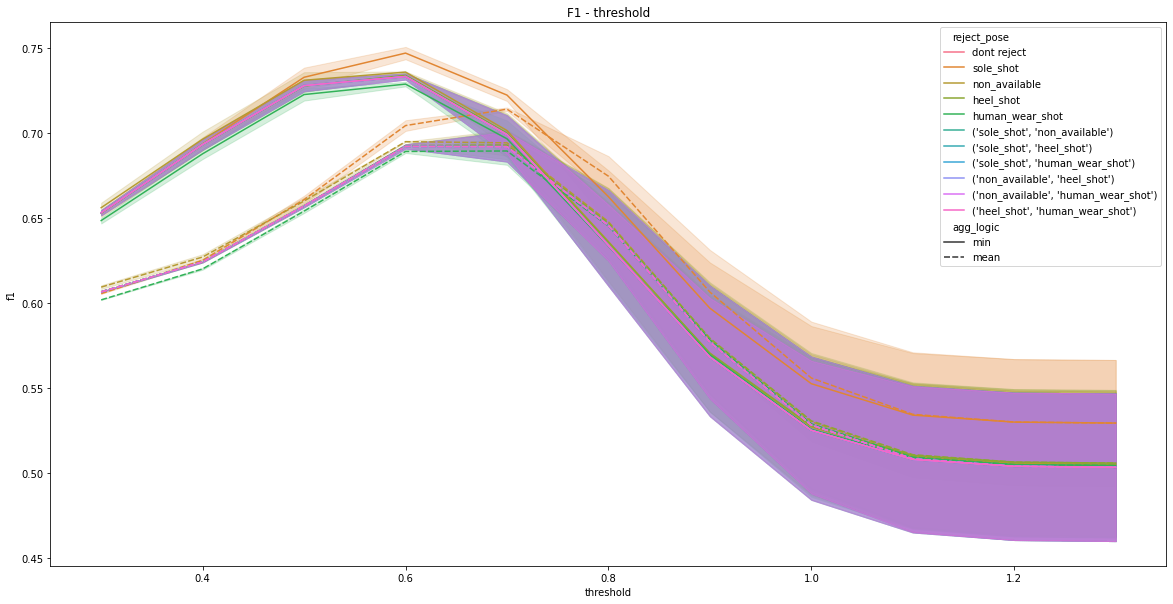

,iou,prec,recall,f1,threshold,agg_logic,reject_pose,block_on_color
25,0.647920,0.858934,0.745418,0.750789,0.6,min,sole_shot,False
267,0.637926,0.883275,0.713209,0.743515,0.6,min,sole_shot,True
289,0.629922,0.865187,0.717224,0.736399,0.6,min,non_available,True
46,0.626151,0.922128,0.671089,0.735930,0.5,min,non_available,False
311,0.628725,0.862638,0.717370,0.735514,0.6,min,heel_shot,True
377,0.628347,0.860898,0.718338,0.735127,0.6,min,"(sole_shot, heel_shot)",True
355,0.628347,0.860898,0.718338,0.735127,0.6,min,"(sole_shot, non_available)",True
421,0.628347,0.860898,0.718338,0.735127,0.6,min,"(non_available, heel_shot)",True
443,0.628347,0.860898,0.718338,0.735127,0.6,min,"(non_available, human_wear_shot)",True
245,0.628347,0.860898,0.718338,0.735127,0.6,min,dont reject,True


In [38]:
def agg_im_matches(
    imids,
    how="min",
    block_on_color=True,
    reject_poses={"sole_shot", "non_available"},
):
    dist_agg = defaultdict(list)
    img_matches = [
        nns[imid] for imid in imids if not df.iloc[imid].pose in reject_poses
    ]

    query_color = pred_df.loc[imids, "color_pred"].mode()[0]
    for im_match in img_matches:
        for imid, dist in im_match:
            if not df.iloc[imid].pose in reject_poses:
                if (not block_on_color) or (df.iloc[imid].color_pred == query_color):
                    dist_agg[imid].append(dist)

    agg_fn = {"min": min, "max": max, "mean": np.mean, "add": sum}[how]
    img_matches = sorted(
        [(imid, agg_fn(dists)) for imid, dists in dist_agg.items()], key=lambda x: x[1]
    )
    return img_matches


sweep = list()
tmp = pred_df.groupby("id").imid.agg(list)
tmp = pred_df.id.map(tmp)

poses_to_reject = [
    "sole_shot",
    "non_available",
    "heel_shot",
    "human_wear_shot",
]
poses_to_reject = (
    ["dont reject"]
    + poses_to_reject
    + list(itertools.combinations(poses_to_reject, 2))
    # + list(itertools.combinations(poses_to_reject, 3))
)

sweep = list()
for block_on_color in tqdm([False, True]):
    for reject_pose in tqdm(poses_to_reject, leave=False):
        for agg_logic in tqdm(["min", "mean"], leave=False):
            agg_tmp = tmp.apply(
                partial(
                    agg_im_matches,
                    how=agg_logic,
                    reject_poses=[reject_pose],
                    block_on_color=block_on_color,
                )
            )
            for threshold in np.arange(0.3, 1.4, 0.1):
                scores = perform_eval(
                    agg_tmp.apply(partial(apply_threshold, threshold=threshold)).apply(
                        imids_to_id
                    )
                )
                scores["threshold"] = threshold
                scores["agg_logic"] = agg_logic
                scores["reject_pose"] = (
                    "--".join(reject_pose)
                    if isinstance(reject_pose, list)
                    else reject_pose
                )
                scores["block_on_color"] = block_on_color
                sweep.append(scores)
sweep = pd.DataFrame(sweep)

plt.figure(figsize=(20, 10))
plt.title("PR Curve")
sns.lineplot(
    x="recall",
    y="prec",
    hue="reject_pose",
    style="agg_logic",
    data=sweep,
)
plt.show()

plt.figure(figsize=(20, 10))
plt.title("F1 - threshold")
sns.lineplot(x="threshold", y="f1", hue="reject_pose", style="agg_logic", data=sweep)
plt.show()

sweep.sort_values("f1", ascending=False).drop_duplicates(subset=["agg_logic", "reject_pose", "block_on_color"]).head(50)

# Analyze popular products 

In [34]:
pdf = pd.read_csv("../../notes/popular.csv")
pdf

,brand,title,gender,master_product,offer_id
0,Nike,Air Max 270 Trainer,men,f45773a1-0dd3-4f16-a5ac-70dcaa45882b,footlocker.314212239504
1,Nike,Air Max 90 LTR Trainer,men,230286c1-0000-4472-930f-8a9a0057e235,footasylum.CZ5594100
2,Nike,Air Max 90 LTR Trainer,men,10a1fd88-1eea-4c6b-88a2-53f6ac1a3add,footlocker.314206402704
3,Nike,Air Max 90 LTR Trainer,men,10a1fd88-1eea-4c6b-88a2-53f6ac1a3add,asos.1666471
4,Nike,Air Max 90 LTR Trainer,men,34303c91-eb38-4a2f-91f8-4d0a785251cb,footasylum.CN8490001
...,...,...,...,...,...
156,New Balance,57/40 Trainer,men,5138bd9d-adf0-4b70-84a1-214adbee1d64,endclothing.3087649156
157,New Balance,57/40 Trainer,men,5138bd9d-adf0-4b70-84a1-214adbee1d64,footasylum.M5740SB1
158,New Balance,57/40 Trainer,men,5138bd9d-adf0-4b70-84a1-214adbee1d64,schuh.3403301150
159,New Balance,57/40 Trainer,men,5138bd9d-adf0-4b70-84a1-214adbee1d64,footlocker.314214787104


In [35]:
pdf.offer_id.isin(df.index).value_counts()

True    161
Name: offer_id, dtype: int64

In [36]:
pdf.offer_id.isin(pred_df.id).value_counts()

False    151
True      10
Name: offer_id, dtype: int64

In [ ]:
# pdf = pdf.drop_duplicates("master_product").reset_index(drop=True)
pred_df = pred_df.loc[pred_df.id.isin(pdf.offer_id), :]
pred_df

In [ ]:
viz(df.loc[pred_df.id.values].drop_duplicates("id"))

In [ ]:
# query_title = df.loc[qid, "title"].values[0]

# sim = df.drop_duplicates("id").title.apply(
#     lambda x: textdistance.damerau_levenshtein.normalized_similarity(query_title, x)
# )
# frame = df.loc[sim.sort_values(ascending=False).iloc[:50].index].drop_duplicates("id").copy()
# frame["im"] = frame.image_url.apply(lambda x: f"<img src='{x}' width=200>")
# display(HTML(frame.to_html(escape=False)))

In [ ]:
nn_imids

In [ ]:
df.iloc[list(nn_imids)]

In [ ]:
for imid, nn_images in pred_df.imid.map(nns).iteritems():
    nn_imids, nn_dists = map(list, zip(*nn_images))
    display(HTML(f"<h1> Ground Truth : {', '.join(pred_df.loc[imid, 'ground_truth'])}</h1><br>"))
    viz(
        df.iloc[nn_imids],
        dist=nn_dists,
        pose=df.iloc[imid].pose,
        # color=df.iloc[imid].color_pred,
    )
    display(HTML("<HR" * 3))


In [ ]:
display(HTML(f"<h1> Query: {qid} </h1>"))
viz(df.loc[qid])=100)
for q, (nn, dists) in nns.items():
    display(HTML("<HR> <h1> UN BLOCKED </h1> <HR>"))
    pd.Series(dists).plot.line(figsize=(12, 4)); plt.show()
    viz(df.iloc[nn], max_images=20, dist=dists)
    display(HTML("<HR> <h1> BLOCKED </h1> <HR>"))
    nn, dists = block_results(nn, dists)
    pd.Series(dists).plot.line(figsize=(12, 4)); plt.show()
    viz(df.iloc[nn], dist=dists)
display(HTML("<HR><HR><HR>"))

## intra and inter distances 

,id,variant_id,title,merchant,brand,gender,color,imid,image_url,image,pose,color_pred,label
0,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87044,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,beige,2002
1,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87045,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,white,2002
2,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87046,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,beige,2002
3,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87047,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,pair_shot,white,2002
4,footasylum.DH9628200,footasylum.DH9628200,Zoom-Type Crater 'Rad Transparency' Trainers,footasylum,nike,men,Multicolour,87048,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,sole_shot,brown,2002
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27280,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86991,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,black,843
27281,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86992,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,side_shot,black,843
27282,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86993,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,pair_shot,navy,843
27283,footasylum.DJ4629002,footasylum.DJ4629002,Asuna Crater Slide,footasylum,nike,men,Multicolour,86994,https://aisle-3-image-final.s3.eu-west-2.amazo...,s3://aisle-3-image-final/images/original/foota...,sole_shot,black,843
